In [3]:
using LinearAlgebra  #####Son las paqueterias que uso, para instalar una paqueteria basta colocar Pkg.add("Nombre_de_la_paqueteria")
using Plots
using SpecialFunctions: gamma
using Random, Distributions
using Alert

Originalmente para obtener el O-H Es de la forma 

$$\kappa_{n+1}  =\kappa_{n}-\gamma_{\kappa}\Delta t (\kappa_{n}- \langle\kappa\rangle)+\sqrt{2D_{\kappa}\Delta t}\Delta W$$
$$\tau_{n+1}  =\tau_{n}-\gamma_{\tau}\Delta t(\tau_{n}-\langle\tau\rangle)+\sqrt{2D_{\tau}\Delta t}\Delta W $$

Pero si dividimos las dos Ecs. entre el promedio de kappa $\langle\kappa\rangle$ y definimos en nuevo paramentro temporal adimensional como $\Delta t^{\prime}=\gamma_{\kappa}\Delta t$, obtenemos:

$$\kappa_{n+1}^{\prime}  =\kappa_{n}^{\prime}-\Delta t^{\prime} (\kappa_{n}^{\prime}- 1)+\sqrt{2D_{\kappa}^{\prime}\Delta t^{\prime}}\Delta W$$
$$\tau_{n+1}^{\prime}  =\tau_{n}^{\prime}-\gamma\Delta t^{\prime}(\tau_{n}^{\prime}-\langle\zeta\rangle)+\sqrt{2D_{\tau}^{\prime}\Delta t^{\prime}}\Delta W $$

Donde $\kappa_{n+1}^{\prime}=\frac{\kappa_{n+1}}{\langle\kappa\rangle}$, $\tau_{n+1}^{\prime}=\frac{\tau_{n+1}}{\langle\kappa\rangle}$, $\gamma=\frac{\gamma_{\tau}}{\gamma_{\kappa}}$, $\langle\zeta\rangle=\frac{\langle\tau\rangle}{\langle\kappa\rangle}$, $D_{\kappa}^{\prime}=\frac{D_{\kappa}}{\gamma_{\kappa}\langle\kappa\rangle^{2}}$, $D_{\tau}^{\prime}=\frac{D_{\tau}}{\gamma_{\kappa}\langle\kappa\rangle^{2}}$

In [4]:
function OUH(x0::Float64,t::AbstractArray,Δt::Float64,D::Float64,γ::Float64=1.0,cte::Float64=1.0) #Proceso de Ornstein–Uhlenbeck
    x=Vector{Float64}(undef, length(t)) #Definimos un vector lleno de basura para luego sobre escribir en el 
    x[1]=x0    #La primera entrada es la condicion inicial del Proceso de Ornstein–Uhlenbeck
    
    for i=1:length(t)-1                 #Usamos un for para poder hacer el proceso
        x0=x0-γ*Δt*(x0-cte)+(sqrt(2*D*Δt)*randn()) # Es el proceso de Ornstein–Uhlenbeck que depende del paso anterior 
        @inbounds x[1+i]=x0                 #@inbounds ignora si la lista tiene el tamaño adecuado y sobreescribimos en la lista basura
    end
    return x                          # Devolvemos la caminata de Ornstein–Uhlenbeck
end

OUH (generic function with 3 methods)

In [5]:
U(K::Float64,T::Float64)=[T/sqrt(K^2+T^2),0,K/sqrt(K^2+T^2)] #Es la función que da el eje de rotación dependiente de la curvatura y la torsión
ϕ(K::Float64,T::Float64,Δt::Float64)=Δt*sqrt(K^2+T^2) #Es la función que da el angulo de rotación

ψ0(ϕ0,ϕ1,u,w)=2*acos(cos(ϕ1/2)*cos(ϕ0/2)-sin(ϕ1/2)*sin(ϕ0/2)*dot(u,w)) # Es la función para generar el primer angulo  resultado de dos "matrices/cuaternios"

# Son las funciones para generar el primer eje resultado de dos "matrices/cuaternios"
w1x(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[1]+cos(ϕ0/2)*sin(ϕ1/2)*u[1])*csc(ψ0/2) 
w1y(ϕ0,ϕ1,u,w,ψ0)=((u[3]*w[1]-w[3]*u[1])*sin(ϕ1/2)*sin(ϕ0/2))*csc(ψ0/2)
w1z(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[3]+cos(ϕ0/2)*sin(ϕ1/2)*u[3])*csc(ψ0/2)


ψn(ϕ0,ϕ1,u,w)=2*acos(cos(ϕ1/2)*cos(ϕ0/2)-sin(ϕ1/2)*sin(ϕ0/2)*dot(u,w)) # Es la función para generar los otros angulos

# Son las funciones para generar los otros ejes resultado
wnx(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[1]+cos(ϕ0/2)*sin(ϕ1/2)*u[1]-(w[2]*u[3])*sin(ϕ0/2)*sin(ϕ1/2))*csc(ψ0/2)
wny(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[2]+(u[3]*w[1]-w[3]*u[1])*sin(ϕ1/2)*sin(ϕ0/2))*csc(ψ0/2)
wnz(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[3]+cos(ϕ0/2)*sin(ϕ1/2)*u[3]+(w[2]*u[1])*sin(ϕ0/2)*sin(ϕ1/2))*csc(ψ0/2)


wnz (generic function with 1 method)

In [6]:
#Acomodamos el eje y el angulo de rotacion en una matriz de euler-rodriguez

MatRot(ω,Ψ)=[ cos(Ψ)+ω[1]^2*(1-cos(Ψ)) ω[1]*ω[2]*(1-cos(Ψ))-ω[3]*sin(Ψ) ω[1]*ω[3]*(1-cos(Ψ))+ω[2]*sin(Ψ);
                ω[2]*ω[1]*(1-cos(Ψ))+ω[3]*sin(Ψ) cos(Ψ)+ω[2]^2*(1-cos(Ψ)) ω[2]*ω[3]*(1-cos(Ψ))-ω[1]*sin(Ψ);
                    ω[3]*ω[1]*(1-cos(Ψ))-ω[2]*sin(Ψ) ω[3]*ω[2]*(1-cos(Ψ))+ω[1]*sin(Ψ) cos(Ψ)+ω[3]^2*(1-cos(Ψ))]

MatRot (generic function with 1 method)

In [7]:
function Trayectoria(Δt::Float64,t::AbstractArray,ω::Array{Array{Float64,1},1},Ψ::Array{Float64,1})

    T_v0=[1.0,0.0,0.0]     #Es el vector tangente inicial
    N_v0=[0.0,1.0,0.0]   #Es el vector tangente inicial
    B_v0=[0.0,0.0,1.0]      #Es el vector tangente inicial
    ##########################################
    T_v=Array{Float64,1}[]       #Lista vacia para todos los vectores tangentes
    N_v=Array{Float64,1}[]       #Lista vacia para todos los vectores tangentes
    B_v=Array{Float64,1}[]       #Lista vacia para todos los vectores tangentes
    for i=1:length(t)                 #For que dura todos los pasos de tiempo
        T_v1=MatRot(ω[i],Ψ[i])*T_v0      #Genera todos los vecotres tangentes a partir del inicial
        N_v1=MatRot(ω[i],Ψ[i])*N_v0      #Genera todos los vecotres tangentes a partir del inicial
        B_v1=MatRot(ω[i],Ψ[i])*B_v0      #Genera todos los vecotres tangentes a partir del inicial
        push!(T_v,real(T_v1))    #Coloca los vectores tangentes en una lista
        push!(N_v,real(N_v1))    #Coloca los vectores tangentes en una lista
        push!(B_v,real(B_v1))    #Coloca los vectores tangentes en una lista
    end
    T_v=transpose(hcat(T_v...))     #Transforma T en algo mejor
    N_v=transpose(hcat(N_v...))     #Transforma N en algo mejor
    B_v=transpose(hcat(B_v...))     #Transforma B en algo mejor
    ##########################################
    #Separaos los componentes de la Tangente
    Tx=T_v[:,1]                 
    Ty=T_v[:,2]
    Tz=T_v[:,3]
    ##########################################
    rx=Float64[]   #Abriremos un array para las posiciones
    ry=Float64[]
    rz=Float64[]
    ###################################
    #Posiciones iniciales
    r1x=0.0
    r1y=0.0
    r1z=0.0
    ############
    # Integramos con un for con la suma de Riemman usual
    for i=1:length(t)
        r1x=Tx[i]*Δt+r1x
        r1y=Ty[i]*Δt+r1y
        r1z=Tz[i]*Δt+r1z
        push!(rx,r1x)
        push!(ry,r1y)
        push!(rz,r1z)
    end
    r=[rx,ry,rz]
    T=[Tx,Ty,Tz]
    N=[N_v[:,1],N_v[:,2],N_v[:,3]]
    B=[B_v[:,1],B_v[:,2],B_v[:,3]]
    return r,T,N,B
end



Trayectoria (generic function with 1 method)

In [8]:
function Trayectoria_qua(K::AbstractArray,T::AbstractArray,t::AbstractArray,Δt::Float64)
    Un=U.(K,T)       # Genera todos los ejes "de las matrices R_n"
    ϕn=ϕ.(K,T,Δt)    # Genera todos los ángulos "de las matrices R_n"
    PASO=length(t)   #Todos los pasos

    ω=Array{Array{Float64,1},1}(undef,PASO) #Aquí iran todas los ejes de rotación
    Ψ=Array{Float64,1}(undef,PASO)           #Aquí iran todos los angulos de rotación 
    ω[1]=Un[1]                            # Es el primero que se genera infinitesimalmente
    Ψ[1]=ϕn[1]                            # Es el primero que se genera infinitesimalmente

    ψ1=ψ0(ϕn[1],ϕn[2],Un[1],Un[2])         #Generamos el primer angulo
    w=[w1x(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),     # Generamos el primer eje
        w1y(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),
        w1z(ϕn[1],ϕn[2],Un[2],Un[1],ψ1)];
    ω[2]=w                                  # Lo colocamos en su respectiva lista
    Ψ[2]=ψ1                                 # Lo colocamos en su respectiva lista
    for i=3:PASO                            #como ya generamos los primeros dos ahora generaremos a partir del tercero todos los demas
        ψ=ψn(ψ1,ϕn[i],Un[i],w)           #Generamos un angulo que depende del anterior y del siguiente infinitesimal
        w=[wnx(ψ1,ϕn[i],Un[i],w,ψ),wny(ψ1,ϕn[i],Un[i],w,ψ),wnz(ψ1,ϕn[i],Un[i],w,ψ)] #Generamos un eje que depende del anterior eje y del siguiente infinitesimal
        ω[i]=w  #Agregamos a las listas
        Ψ[i]=ψ1 #Agregamos a las listas
        ψ1=ψ    #Reescribimos
    end
    
    r,Tm,Nm,Bm=Trayectoria(Δt,t,ω,Ψ) #Llamamos a la función trayectoria para que con los angulos y los ejes construya la trayectoria
    
    return r,Tm,Nm,Bm
end

Trayectoria_qua (generic function with 1 method)

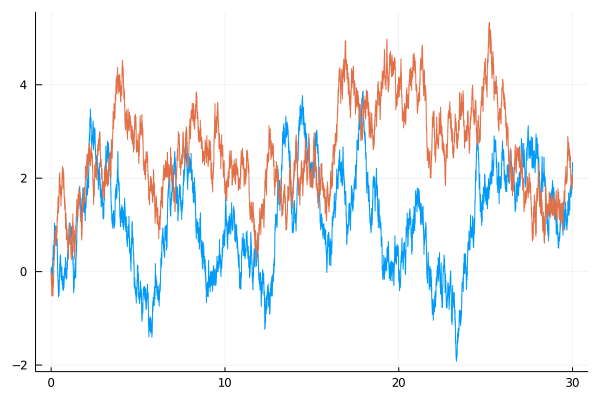

In [40]:
k0=0.01
t0=0.01

γ=1.0

DK=1.0
DT=1.0

N=30.0

Δt=0.001

t=0:Δt:N

cte1=3.0

K=OUH(k0,t,Δt,DK)
T=OUH(t0,t,Δt,DT,γ,cte1)
plot(t,K,legend=false)
plot!(t,T,legend=false)

In [41]:
@time r,Tm,Nm,Bm=Trayectoria_qua(K,T,t,Δt);

  0.127023 seconds (1.68 M allocations: 63.183 MiB, 7.59% gc time)


In [42]:
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
P1=plot(r[1],r[2],r[3], legend=false,title="3D",aspect_ratio=:equal,xlabel="x",ylabel="y",zlabel="z")
P2=plot(r[1],r[2],legend=false,title="Plano XY",xlabel="x",ylabel="y")
P3=plot(r[1],r[3],legend=false,title="Plano XZ",xlabel="x",ylabel="z")
P4=plot(r[2],r[3],legend=false,title="Plano YZ",xlabel="y",ylabel="z")
plot(P1,P2,P3,P4,layout=l)
#savefig("./Trayectorias_3D/Trayectoria_3D_gamK=$(γK)_gam=$(γT)_etaK=$(ηK)_etaT=$(ηT)_k0=$(k0)_t0=$(t0)_ck=_$(ctek)ct=$(ctet).png")

In [22]:
plot(Tm[1],Tm[2],Tm[3], legend=false)
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
P1=plot(Tm[1],Tm[2],Tm[3], legend=false,title="3D",aspect_ratio=:equal)
P2=plot(Tm[1],Tm[2],legend=false,title="XY",aspect_ratio=:equal)
P3=plot(Tm[1],Tm[3],legend=false,title="XZ",aspect_ratio=:equal)
P4=plot(Tm[2],Tm[3],legend=false,title="YZ",aspect_ratio=:equal)
plot(P1,P2,P3,P4,layout=l)

In [23]:
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
P1=plot(Nm[1],Nm[2],Nm[3], legend=false,title="3D",aspect_ratio=:equal)
P2=plot(Nm[1],Nm[2],legend=false,title="XY",aspect_ratio=:equal)
P3=plot(Nm[1],Nm[3],legend=false,title="XZ",aspect_ratio=:equal)
P4=plot(Nm[2],Nm[3],legend=false,title="YZ",aspect_ratio=:equal)
plot(P1,P2,P3,P4,layout=l)


In [24]:
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
P1=plot(Bm[1],Bm[2],Bm[3], legend=false,title="3D",aspect_ratio=:equal)
P2=plot(Bm[1],Bm[2],legend=false,title="XY",aspect_ratio=:equal)
P3=plot(Bm[1],Bm[3],legend=false,title="XZ",aspect_ratio=:equal)
P4=plot(Bm[2],Bm[3],legend=false,title="YZ",aspect_ratio=:equal)
plot(P1,P2,P3,P4,layout=l)